# Algorithms for Threat Detection Data
By Zhonghao Zhao and Bingxue An, under advise of Professor Bo Li

In [1]:
# import packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import math
import warnings
warnings.filterwarnings('ignore')
import sys
!{sys.executable} -m pip install pandas-profiling
import pandas_profiling

spyder 3.3.2 requires pyqt5<5.10; python_version >= "3", which is not installed.
distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# read data
data_number = [1,2,3]
dataset = pd.read_csv("DATA/"+ "AIS_Challenge_Problem_Set_0_"+ str(1) + "_withVID.csv")
dataset.info()
dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13714 entries, 0 to 13713
Data columns (total 7 columns):
OBJECT_ID             13714 non-null int64
VID                   13714 non-null int64
SEQUENCE_DTTM         13714 non-null object
LAT                   13714 non-null float64
LON                   13714 non-null float64
SPEED_OVER_GROUND     13714 non-null int64
COURSE_OVER_GROUND    13714 non-null int64
dtypes: float64(2), int64(4), object(1)
memory usage: 750.1+ KB


,OBJECT_ID,VID,SEQUENCE_DTTM,LAT,LON,SPEED_OVER_GROUND,COURSE_OVER_GROUND
0,1,100008,14:00:00,36.906850,-76.089022,1,1641
1,2,100015,14:00:00,36.950000,-76.026834,11,2815
2,3,100016,14:00:00,36.906783,-76.089084,0,2632
3,4,100019,14:00:00,37.003000,-76.283167,148,2460
4,5,100016,14:00:01,36.906783,-76.089084,0,2632


In [3]:
#check whether there is missing values in the data
dataset.isnull().sum()

OBJECT_ID             0
VID                   0
SEQUENCE_DTTM         0
LAT                   0
LON                   0
SPEED_OVER_GROUND     0
COURSE_OVER_GROUND    0
dtype: int64

In [4]:
#summary of the data
#pandas_profiling.ProfileReport(dataset)

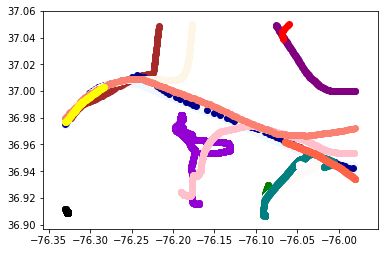

In [7]:
#Glimpse at all the vessel tracks
cnames = ['aliceblue', 'brown', 'darkblue', 'darkviolet', 'gold', 'gray', 'green', 'hotpink', 'oldlace', 'pink','purple',
'red', 'salmon', 'silver', 'snow', 'teal','tomato', 'white', 'yellow','black']
for vid in range(100001,100021):
    sample = dataset[dataset.VID == vid]
    temp_x = [element.LAT for element in sample.itertuples()]
    temp_y = [element.LON for element in sample.itertuples()]
    x = np.array(temp_x)
    y = np.array(temp_y)
    plt.scatter(y,x, c = cnames[vid-100001])

In [8]:
# A method to convert HH-MM-SS to seconds
def get_sec(time_str):
    h, m, s = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)

# a node class for each data
class Vessel_node:
    def __init__(self, object_id, time, lat, lon, speed, direction):
        self.OBJECT_ID = object_id
        self.VID = -1
        self.Time = time
        self.LAT = lat
        self.LON = lon
        self.Speed = speed*0.514444
        self.Direction = direction
    
    def set_VID(self, vid):
        self.VID = vid
    
    def get_ID(self):
        return self.OBJECT_ID
    
    def get_LAT(self):
        return self.LAT
    
    def get_LON(self):
        return self.LON
    
    def get_Time(self):
        return self.Time
    
    def get_SPEED(self):
        return self.Speed
    
    def get_DIRECTION(self):
        return self.Direction
    
# a track class to keep all tracks
class All_tracks:
    def __init__(self):
        self.tracks = []
        self.total_track = 0
        self.node_tracks = []
    
    def get_total_track(self):
        return self.total_track
        
    def add_track(self, node):
        new_track = [node.get_ID()]
        new_node_track = [node]
        self.total_track += 1
        node.set_VID(self.total_track)
        self.tracks.append(new_track)
        self.node_tracks.append(new_node_track) 
     
    def add_node(self, track_id, node):
        node.set_VID(track_id)
        self.tracks[track_id - 1].append(node.get_ID())
        self.node_tracks[track_id - 1].append(node)
    
    def print_track(self):
        for track in self.tracks:
            print(track)
            print('\n')
        
    def print_track_number(self):
        print(self.total_track)
    
    def get_node_track(self):
        return self.node_tracks
    
    def get_track_number(self):
        return self.total_track

In [9]:
#test to group all exisiting tracks into our own all_track class, get expect result
tracker = All_tracks()
for vid in range(100001, 100021):
    sample = dataset[dataset.VID == vid]
    all_id = np.array(sample.OBJECT_ID)
    counter = 0
    for cur_id in all_id:
        temp_1 = sample[sample.OBJECT_ID == cur_id]
        temp_1 = temp_1.iloc[0]
        a = temp_1.tolist()
        node_1 = Vessel_node(a[0],get_sec(a[2]), a[3], a[4], a[5]/10, a[6]/10)
        if(counter == 0):
            tracker.add_track(node_1)
        else:
            tracker.add_node(tracker.get_total_track(), node_1)
        
        counter += 1

tracker.print_track_number()

20


In [10]:
'''The initial assumption is the accleration is constant between two nodes, use v_1-v_0 / (t_1-t_0) to calculate 
the accleration, use v_0*t + 0.5*a*t^2 to calculate the desired final x, y location, then compare it with the final 
x, y location, calculate the desired distance difference sqrt (x_expect-x)^2 + (y_expect-y)^2 for every track, compare
it with the actual distane, using actual lon and lat to calculate
'''
def calculate_distance(lat2, lon2, lat1, lon1):
    R = 6371000; #earth radian
    l_1 = math.radians(lat1)
    l_2 = math.radians(lat2)
    lat_diff = math.radians(lat2-lat1)
    lon_diff = math.radians(lon2-lon1)
    temp = math.sin(lat_diff/2)**2 + math.cos(l_1) * math.cos(l_2) * math.sin(lon_diff/2)**2
    c = 2 * math.atan2(math.sqrt(temp), math.sqrt(1-temp))
    d = R * c
    return d

all_nodes = tracker.get_node_track()
all_max_error = np.zeros(tracker.get_track_number())
all_median_error = np.zeros(tracker.get_track_number())
for i in range(0,len(all_nodes)):
    total_nodes = len(all_nodes[i])
    error_array = np.zeros(total_nodes-1)
    for j in range(0,total_nodes-1):
        a = all_nodes[i][j]
        b = all_nodes[i][j+1]
        angle_1 = math.radians(a.get_DIRECTION())
        angle_2 = math.radians(b.get_DIRECTION())
        v_diff_x = b.get_SPEED()*math.cos(angle_2) - a.get_SPEED()*math.cos(angle_1)
        v_diff_y = b.get_SPEED()*math.sin(angle_2) - a.get_SPEED()*math.sin(angle_1)
        t_diff = b.get_Time()- a.get_Time()
        acc_x = v_diff_x / t_diff
        acc_y = v_diff_y / t_diff
        lon_diff_expect = a.get_SPEED()*math.cos(angle_1)*t_diff + 0.5*acc_x*t_diff**2
        lat_diff_expect = a.get_SPEED()*math.sin(angle_1)*t_diff + 0.5*acc_y*t_diff**2
        total_diff = math.sqrt(lon_diff_expect**2 + lat_diff_expect**2)
        d = calculate_distance(b.get_LAT(), b.get_LON(), a.get_LAT(), b.get_LON())
        error_array[j] = (abs(d)-abs(total_diff))**2
    all_max_error[i] = max(error_array)
    all_median_error[i] = np.median(error_array)

print(all_max_error)
print(all_median_error)

[1.65736196e+04 3.93629223e+04 1.91536464e+06 1.53403882e+03
 3.61431463e+00 3.51285075e+00 1.17096806e+03 2.05047128e+00
 6.35067162e+03 4.45784630e+04 1.39219620e+04 1.10373534e+05
 8.99179401e+04 3.44828289e+02 2.71587776e+03 1.41461777e+04
 3.82783549e+03 9.29820017e+02 1.25649458e+03 2.05952581e+03]
[1.62672485e+03 2.75398858e+03 6.85144993e+04 2.88206713e+00
 7.39923825e-02 8.50641141e-02 9.61569942e-02 8.52840689e-02
 5.36523094e+02 7.05283732e+02 3.60882220e+02 1.89895505e+03
 9.86718456e+03 0.00000000e+00 3.20209928e-01 0.00000000e+00
 8.47630865e+02 0.00000000e+00 2.81312636e+02 3.16526380e+00]


In [21]:
thresheld = 10*np.max(all_median_error)
print(math.sqrt(thresheld))
new_tracker = All_tracks()
for index, row in dataset.iterrows():
    a = row.tolist()
    node = Vessel_node(a[0],get_sec(a[2]), a[3], a[4], a[5]/10, a[6]/10)
    if(index == 0):
        new_tracker.add_track(node)
    else:
        node_tracks = new_tracker.get_node_track()
        smallest, track_id = thresheld, -1
        for i in range(new_tracker.get_track_number()):
            each_track = node_tracks[i]
            if(each_track[-1].get_Time() == node.get_Time()):
                continue
            else:
                a = each_track[-1]
                b = node
                angle_1 = math.radians(a.get_DIRECTION())
                angle_2 = math.radians(b.get_DIRECTION())
                v_diff_x = b.get_SPEED()*math.cos(angle_2) - a.get_SPEED()*math.cos(angle_1)
                v_diff_y = b.get_SPEED()*math.sin(angle_2) - a.get_SPEED()*math.sin(angle_1)
                t_diff = b.get_Time()- a.get_Time()
                acc_x = v_diff_x / t_diff
                acc_y = v_diff_y / t_diff
                lon_diff_expect = a.get_SPEED()*math.cos(angle_1)*t_diff + 0.5*acc_x*t_diff**2
                lat_diff_expect = a.get_SPEED()*math.sin(angle_1)*t_diff + 0.5*acc_y*t_diff**2
                total_diff = math.sqrt(lon_diff_expect**2 + lat_diff_expect**2)
                d = calculate_distance(b.get_LAT(), b.get_LON(), a.get_LAT(), b.get_LON())
                error = (abs(d)-abs(total_diff))**2
                if(error < thresheld and error < smallest):
                    smallest = error
                    track_id = i+1
        
        if(track_id == -1):
            new_tracker.add_track(node)
        else: 
            new_tracker.add_node(track_id, node)


new_tracker.print_track_number()

827.7348567654531
20


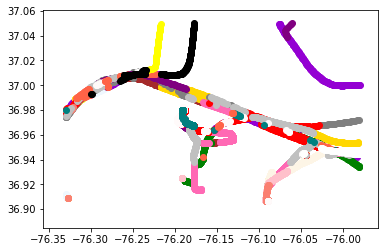

In [22]:
all_vessels = new_tracker.get_node_track()
cnames = ['aliceblue', 'brown', 'darkblue', 'darkviolet', 'gold', 'gray', 'green', 'hotpink', 'oldlace', 'pink','purple',
'red', 'salmon', 'silver', 'snow', 'teal','tomato', 'white', 'yellow', 'black']
for i in range(new_tracker.get_track_number()):
    track = all_vessels[i]
    temp_x = np.zeros(len(track))
    temp_y = np.zeros(len(track))
    counter = 0
    for element in track:
        temp_x[counter] = element.get_LON()
        temp_y[counter]= element.get_LAT()
        counter += 1
    x = np.array(temp_x)
    y = np.array(temp_y)
    plt.scatter(x,y, c = cnames[i])